<a href="https://colab.research.google.com/github/matidan01/DataIntensive/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Previsioni dei Podii Olimpici: Analisi delle Tendenze Storiche

Progetto di Programmazione di Applicazioni Data Intensive
a.a. 2023/2024

 **Realizzato da:**

 Mazzoni Gaia (gaia.mazzoni2@studio.unibo.it)

 D'Antino Matilde (matilde.dantino@studio.unibo.it)

Nel contesto delle competizioni olimpiche, prevedere i risultati e i medagliati è una sfida complessa, che richiede un'analisi approfondita dei dati storici. Il nostro progetto si propone di sviluppare un modello predittivo per anticipare i podi delle competizioni olimpiche, utilizzando un dataset completo che copre tutte le edizioni delle Olimpiadi dal 1896 al 2022.

# Caricamento Librerie


Le librerie necessarie per le operazioni sono le seguenti:


1.   Numpy
2.   pandas
3.   Matplotlib
...

Di seguito l'importazione di tali librerie.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caricamento dei dati


Il dataset contenente tutte le informazioni necessarie proviene dal sito Kaggle, reperibile attraverso il link:
[dataset_olimpiadi_1896-2022](https://www.kaggle.com/datasets/piterfm/paris-2024-olympic-summer-games).

Questo dataset storico sui Giochi Olimpici include tutte le edizioni dalla prima Olimpiade di Atene nel 1896 fino a quella di Pechino nel 2022. Contiene risultati, medaglie, atleti e città ospitanti.
Il dataset comprende oltre 21.000 medaglie, 162.000 risultati, 74.000 atleti, 20.000 biografie e 53 città ospitanti dei Giochi Olimpici estivi e invernali.


## Significato delle colonne

Il dataset è costituito da 4 tabelle:
- olympic_athletes.csv
- olympic_hosts.csv
- olympic_medals.csv
- olympic_results.csv

Per il fine della nostra analisi verrà utilizzato quasi unicamente il dataset olympic_results.csv, con l'eccezione dell'uso di olympic_athletes.csv in alcuni casi.

Le feature presenti nel Dataset olympic_results sono:

1. `discipline_title`: Il nome della disciplina sportiva.
2.  `event_title`: Il titolo dell'evento specifico all'interno della disciplina.
3. `slug_game`: L'identificatore unico della specifica edizione dei Giochi Olimpici. Ad esempio, "beijing-2022".
4. `participant_type`: Il tipo di partecipante, che può essere individuale (Athlete) o di squadra (GameTeam).
5. `medal_type`: Il tipo di medaglia vinta (oro, argento, bronzo). Ad esempio, può essere vuoto se non è stata vinta alcuna medaglia.
6. `athletes`: L'elenco degli atleti che partecipano, insieme ai loro URL di profilo. Questo può essere vuoto se l'informazione è specificata nelle colonne athlete_url e athlete_full_name.
7. `rank_equal`:  Indica se più partecipanti hanno la stessa posizione in classifica. Ad esempio, "False" (significa che la posizione non è condivisa con altri).
8. `rank_position`: La posizione in classifica dell'atleta o della squadra.
9. `country_name`: Il nome del paese dell'atleta o della squadra.
10. `country_code`: Il codice a due lettere del paese.
11. `country_3_letter_code`: Il codice a tre lettere del paese.
12. `athlete_url`:  URL del profilo dell'atleta.
13. `athlete_full_name`: Il nome completo dell'atleta.
14. `value_unit`: L'unità di misura del risultato. Ad esempio, "POINTS".
15. `value_type`:  Il tipo di risultato o misura.

La variabile che tenteremo di predire è:
- `medal_type`: Il tipo di medaglia vinta (oro, argento, bronzo).

Per prima cosa, è necessario importare i dataset.

In [ ]:
athletes = pd.read_csv("olympic_athletes.csv")
#hosts = pd.read_csv("olympic_hosts.csv")
#medals = pd.read_csv("olympic_medals.csv")

file_path = "olympic_results.csv"

results = pd.read_csv(file_path, index_col=0)

Vediamo che aspetto ha il dataset, e quanto spazio occupa:

In [ ]:
results.info(verbose = False, memory_usage="deep")
results.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 162804 entries, Curling to Gymnastics Artistic
Columns: 14 entries, event_title to value_type
dtypes: object(14)
memory usage: 137.7 MB


,event_title,slug_game,participant_type,medal_type,athletes,rank_equal,rank_position,country_name,country_code,country_3_letter_code,athlete_url,athlete_full_name,value_unit,value_type
discipline_title,,,,,,,,,,,,,,
Curling,Mixed Doubles,beijing-2022,GameTeam,GOLD,"[('Stefania CONSTANTINI', 'https://olympics.co...",False,1,Italy,IT,ITA,NaN,NaN,NaN,NaN


Osserviamo che sono presenti 14 features e tutte di tipo 'object', occupando 137.7MB.
Decidiamo quindi di ricaricare il dataset gestendo i dati meno complessi come categorici ("discipline_title", "event_title", "slug_game", "participant_type", "medal_type", "country_name", "country_code", "country_3_letter_code"), boolean ("rank_equal") o float ("rank_position"). Inoltre per quanto riguarda la colonna "rank_position" per comodità vengono convertiti i valori non numerici come "DNS" in valori di tipo NaN.

In [ ]:
categorical = ["discipline_title", "event_title", "slug_game", "participant_type", "medal_type",
               "country_name", "country_code", "country_3_letter_code"]

results = pd.read_csv(file_path, index_col=0, dtype={x:"category" for x in categorical})
results['rank_equal'] = results['rank_equal'].astype('bool')
results['rank_position'] = pd.to_numeric(results['rank_position'], errors='coerce')

results.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 162804 entries, Curling to Gymnastics Artistic
Columns: 14 entries, event_title to value_type
dtypes: bool(1), category(7), float64(1), object(5)
memory usage: 49.1 MB


Notiamo come il dataset così caricato sia di 49.1MB ovvero il 30% di prima della conversione dei dati.

Notiamo, inoltre, che alcune features sono ripetute (ad esempio: country_name, country_code e country_3_letter_code). Possiamo quindi eliminare le colonne per risparmiare spazio.

In [ ]:
import ast
import re

def extract_year(slug_game):
    return slug_game.split('-')[-1]

def remove_urls(athletes_str):
    if pd.isna(athletes_str):
        return athletes_str
    athletes_list = ast.literal_eval(athletes_str)
    names_only = [name for name, url in athletes_list]
    return ', '.join(names_only)

results['athletes'] = results['athletes'].apply(remove_urls)

results['slug_game'] = results['slug_game'].apply(extract_year)

results['athletes'] = results['athletes'].fillna(results['athlete_full_name'])

results.drop(columns=["country_code", "country_3_letter_code", "athlete_url", "medal_type", "athlete_full_name"], inplace=True)

results.replace('nan', np.nan, inplace=True)


In [ ]:
results.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 162804 entries, Curling to Gymnastics Artistic
Columns: 9 entries, event_title to value_type
dtypes: bool(1), category(3), float64(1), object(4)
memory usage: 37.8 MB


# Analisi generale dei dati

Per comprendere appieno i dati su cui si dovrà lavorare, li andiamo ora a visualizzare, tramite grafici e statistiche.

A livello quantitativo, i dati si presentano in questo modo:

In [ ]:
res = results.copy()
res.reset_index(inplace=True)
res = res.dropna(subset=['athletes'])

res['athletes'] = res['athletes'].astype(str)
res['athletes'] = res['athletes'].apply(lambda x: x.split(', '))
res = res.explode('athletes')

# Variazione dei dati
print("Variazione dei dati")

#for x in ["discipline_title", "event_title", "slug_game", "participant_type", "athletes", "rank_equal", "rank_position", "country_name", "value_unit", "value_type"]:
    #print(x+":  \t"+ str(res[x].nunique()))

for x in ["discipline_title", "event_title", "slug_game", "country_name"]:
    print(x+":  \t"+ str(res[x].nunique()))

Variazione dei dati
discipline_title:  	68
event_title:  	1278
slug_game:  	37
country_name:  	237


I dati in nostro possesso coprono 68 discipline sportive, con più di 1200 sottocategorie di discipline, i cui dati sono stati raccolti da 37 edizioni dei Giochi Olimpici. Ai giochi hanno partecipato 237 Paesi.

In [ ]:
print('\n\nStatistiche feature rank_position')

#Descrizioni
print(results["rank_position"].describe())

print('\n\nStatistiche feature country_name')
#Descrizioni
print(results["country_name"].describe())



Statistiche feature rank_position
count     158926
unique       193
top            9
freq        8279
Name: rank_position, dtype: object


Statistiche feature country_name
count                       162804
unique                         238
top       United States of America
freq                         11916
Name: country_name, dtype: object


In [ ]:
results['athletes'] = results['athletes'].str.replace(', Jr', ' Jr')
results.replace('- -', np.nan, inplace=True)

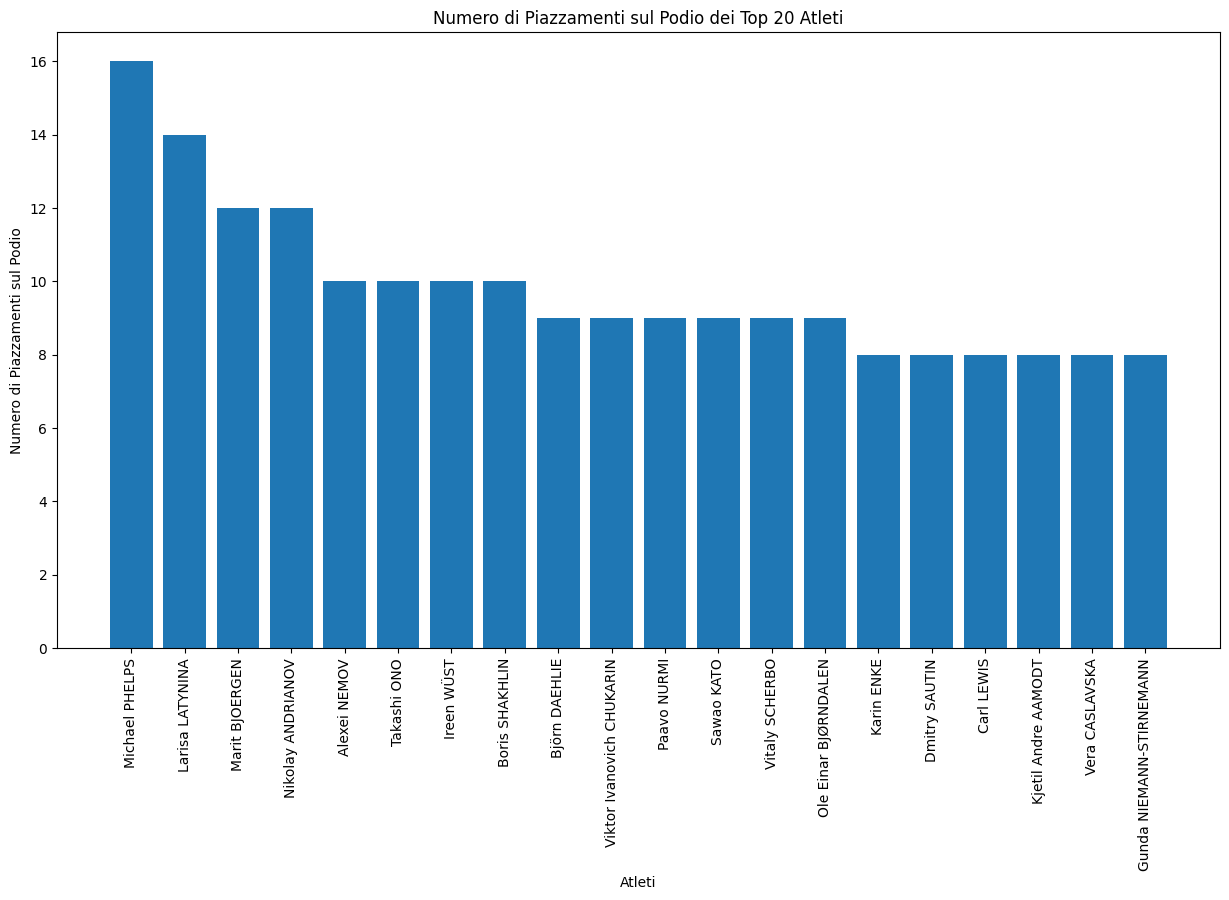

In [ ]:
#voglio trovare gli atleti con il maggior numero di vittorie

#questo metodo mi restituisce un dizionario (nome, vittorie per eventi)
def get_all_athletes_and_podiums(athletes_results):
  all_athletes = {}
  for athlete in athletes_results['athletes']:
    if not pd.isna(athlete):
      athlete_list = athlete.split(", ")
      for a in athlete_list:
        if a in all_athletes:
          all_athletes[a] += 1
        else:
          all_athletes[a] = 1
  return all_athletes

filtered_results = results[results['rank_position'] <= 3.0]
athletes_and_podiums = get_all_athletes_and_podiums(filtered_results)

data = {
    'Athlete' : athletes_and_podiums.keys(),
    'TimesOnPodium' : athletes_and_podiums.values()
}

df_athletes_and_podiums = pd.DataFrame(data)
top_20_participants = df_athletes_and_podiums.sort_values(by='TimesOnPodium', ascending=False).head(20)


plt.figure(figsize=(15, 8))
bars = plt.bar(top_20_participants['Athlete'], top_20_participants['TimesOnPodium'])

for bar in bars:
    yval = bar.get_height()

plt.xticks(rotation=90)
plt.xlabel('Atleti')
plt.ylabel('Numero di Piazzamenti sul Podio')
plt.title('Numero di Piazzamenti sul Podio dei Top 20 Atleti')
plt.show()

<ipython-input-159-9425216cd851>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  athletes_per_country = exploded_df.groupby('country_name')['athletes'].count().reset_index()


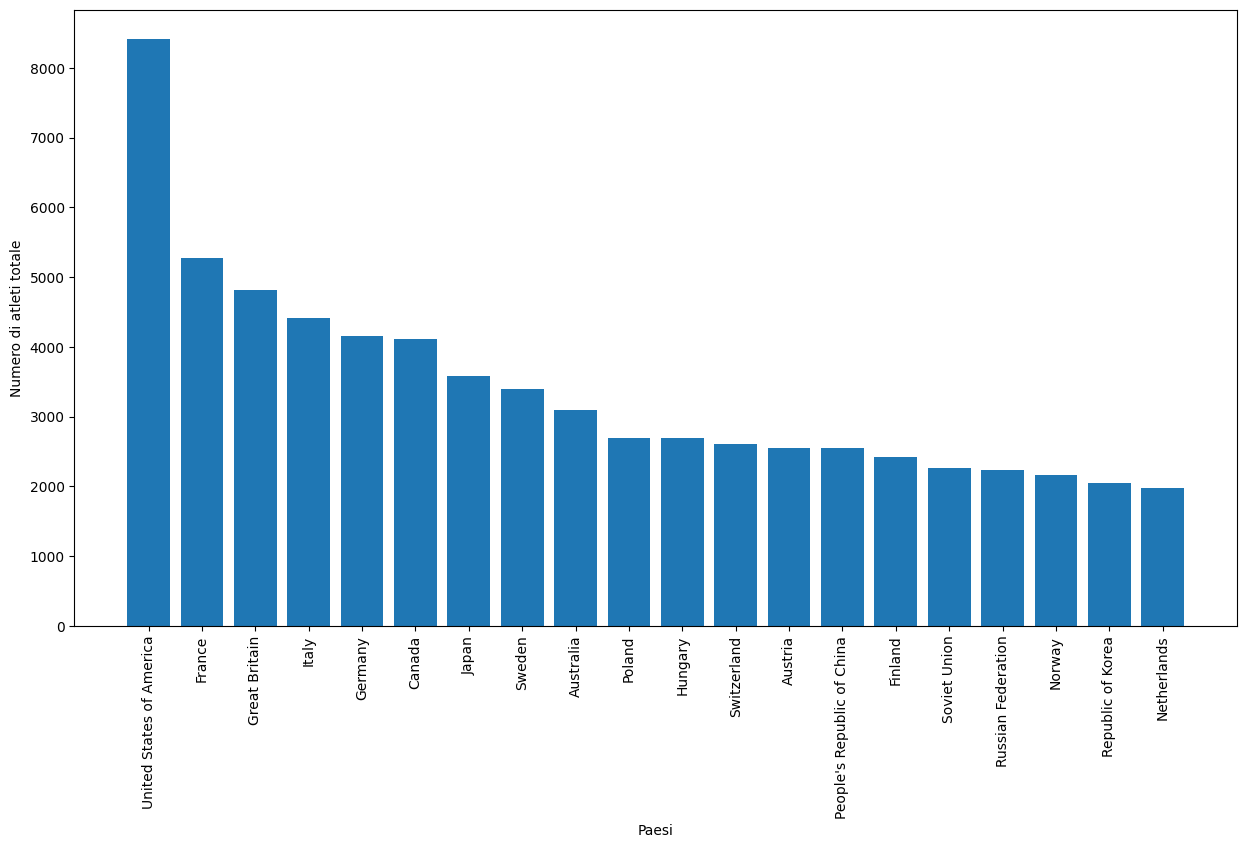

In [ ]:
#plot bar numero atleti

exploded_df = results.assign(athlete=results['athletes'].str.split(', ')).explode('athlete')
exploded_df = exploded_df.drop_duplicates(subset=['athlete', 'slug_game'])
athletes_per_country = exploded_df.groupby('country_name')['athletes'].count().reset_index()
athletes_per_country.columns = ['CountryName', 'NumberOfAthletes']

highest_sending_countries = athletes_per_country.sort_values(by='NumberOfAthletes', ascending=False).head(20)

plt.figure(figsize=(15, 8))
bars = plt.bar(highest_sending_countries['CountryName'], highest_sending_countries['NumberOfAthletes'])

for bar in bars:
    yval = bar.get_height()

plt.xticks(rotation=90)
plt.xlabel('Paesi')
plt.ylabel('Numero di atleti totale')
plt.show()

Iniziamo ad analizzare i dati inseriti nel dataset studiando la variazione dei dati e le statistiche di alcune delle features più importanti

Dalla variazione dei dati vediamo che vengono trattare 67 diverse discipline in 37 edizioni delle olimpiadi. Gli atleti che hanno partecipato sono più di 75000 divisi in 234 nazioni e con una posizione in classifica massima di 185.

Per calcolare la media del numero di atleti partecipanti alle diverse edizioni delle Olimpiadi per ciascun paese, eseguiamo le seguenti operazioni:

1. **Calcolo della Media per Paese**: Determiniamo la media del numero di atleti partecipanti per ogni paese in ciascuna edizione delle Olimpiadi. Successivamente, mostriamo i 10 paesi con le medie più alte.

2. **Calcolo della Media per Disciplina e Categoria**: Analogamente, calcoliamo la media del numero di atleti partecipanti per ogni disciplina e la sua rispettiva categoria in ogni edizione delle Olimpiadi. Anche in questo caso, mostriamo le 10 discipline con le medie più alte.


In [ ]:
# Numero medio di partecipanti per paese ad olimpiade
athlete_counts = res.groupby(['slug_game', 'country_name'], observed=False).size().reset_index(name='athlete_count')
average_counts = athlete_counts.groupby('country_name', observed=False)['athlete_count'].mean().reset_index(name='average_athletes')

print(average_counts.sort_values("average_athletes").tail(10))

print("\n\n")

# Numero medio di partecipanti per sport ad olimpiade
participant_counts = res.groupby(['discipline_title', 'event_title', 'slug_game'], observed=False).size().reset_index(name='participant_count')
average_participants = participant_counts.groupby(['discipline_title', 'event_title'], observed=False).agg({
    'participant_count': 'mean'
}).reset_index()

print(average_participants.sort_values("participant_count").tail(10))

                 country_name  average_athletes
190               Switzerland        101.513514
10                  Australia        107.351351
189                    Sweden        132.378378
98                      Japan        134.729730
34                     Canada        151.540541
73                    Germany        152.729730
95                      Italy        161.432432
75              Great Britain        167.405405
69                     France        194.513514
207  United States of America        309.621622



           discipline_title                   event_title  participant_count
44792    Equestrian Jumping              individual mixed          28.648649
78506              Shooting  50m rifle prone 60 shots men          29.459459
86812           Ski Jumping    Normal Hill Individual men          31.054054
25219  Cross Country Skiing                      50km men          32.270270
2448          Alpine Skiing                  downhill men          32.297297
2526   

Visualizziamo la distribuzione complessiva delle medaglie vinte da diversi paesi in tutte le edizioni delle Olimpiadi disponibili. Per farlo, creiamo un grafico a torta che mostra come le medaglie sono suddivise tra i vari paesi. Questo grafico ci permetterà di osservare chiaramente quale paese ha ottenuto la maggiore percentuale di medaglie rispetto agli altri.

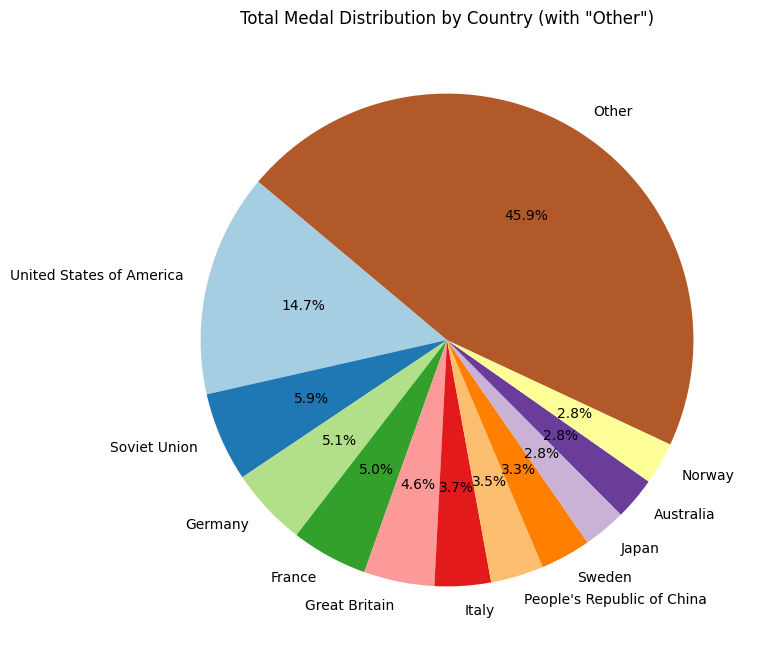

In [ ]:
valid_ranks = [1, 2, 3]
filtered_results = results[results['rank_position'].isin(valid_ranks)]

total_medals = filtered_results['country_name'].value_counts()

total_medals_percent = (total_medals / total_medals.sum()) * 100

# Identifica i paesi con percentuale inferiore al 2.5%
small_countries = total_medals_percent[total_medals_percent < 2.75].index
total_medals.loc['Other'] = total_medals[total_medals.index.isin(small_countries)].sum()
total_medals = total_medals[~total_medals.index.isin(small_countries)]

plt.figure(figsize=(16, 8))

plt.pie(
    total_medals,
    labels=total_medals.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired(range(len(total_medals)))
)

plt.title('Total Medal Distribution by Country (with "Other")', fontsize=12)
plt.show()

Osserviamo una correlazione tra il numero di atleti in gara e il numero di medaglie vinte. Per visualizzare questa correlazione, creiamo un grafico a dispersione che mostra il numero di medaglie vinte in funzione del numero di atleti partecipanti.

Il grafico evidenzia come, con l'aumentare del numero di atleti in gara, il numero di medaglie vinte tende ad aumentare. Inoltre, per chiarire ulteriormente questa relazione, aggiungiamo una retta di regressione lineare al grafico. Questa retta di regressione fornisce una rappresentazione del trend generale e ottimizza al meglio la correlazione tra il numero di atleti e le medaglie vinte.

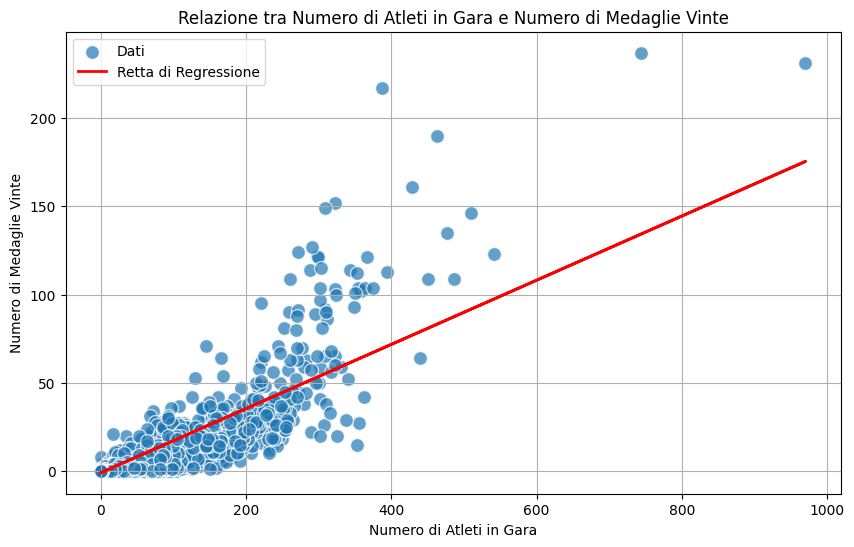

In [ ]:
from sklearn.linear_model import LinearRegression

athlete_counts = res.groupby(['slug_game', 'country_name'], observed=False).size().reset_index(name='athlete_count')

medal_results = results[results['rank_position'].isin([1, 2, 3])]
medal_counts = medal_results.groupby(['slug_game', 'country_name'], observed=False).size().reset_index(name='medal_count')

merged_data = pd.merge(athlete_counts, medal_counts, on=['slug_game', 'country_name'], how='left')

merged_data['athlete_count'] = pd.to_numeric(merged_data['athlete_count']).fillna(0)
merged_data['medal_count'] = pd.to_numeric(merged_data['medal_count']).fillna(0)

plt.figure(figsize=(10, 6))

plt.scatter(merged_data['athlete_count'], merged_data['medal_count'], alpha=0.7, edgecolors='w', s=100, label='Dati')

X = merged_data[['athlete_count']].values.reshape(-1, 1)
y = merged_data['medal_count'].values

model = LinearRegression().fit(X, y)
predictions = model.predict(X)

plt.plot(merged_data['athlete_count'], predictions, color='red', linewidth=2, label='Retta di Regressione')

plt.xlabel('Numero di Atleti in Gara')
plt.ylabel('Numero di Medaglie Vinte')
plt.title('Relazione tra Numero di Atleti in Gara e Numero di Medaglie Vinte')
plt.legend()
plt.grid(True)
plt.show()
#ciao

Vogliamo creare un grafico che illustra come il numero di medaglie vinte da diversi paesi varia attraverso le diverse edizioni delle Olimpiadi disponibili. Per concentrare l'attenzione sui principali protagonisti, mostreremo solo i primi 10 paesi con il maggior numero di medaglie. Questo grafico permetterà di osservare le fluttuazioni e le tendenze nel tempo riguardo alle prestazioni di questi paesi nelle diverse edizioni dei giochi olimpici.

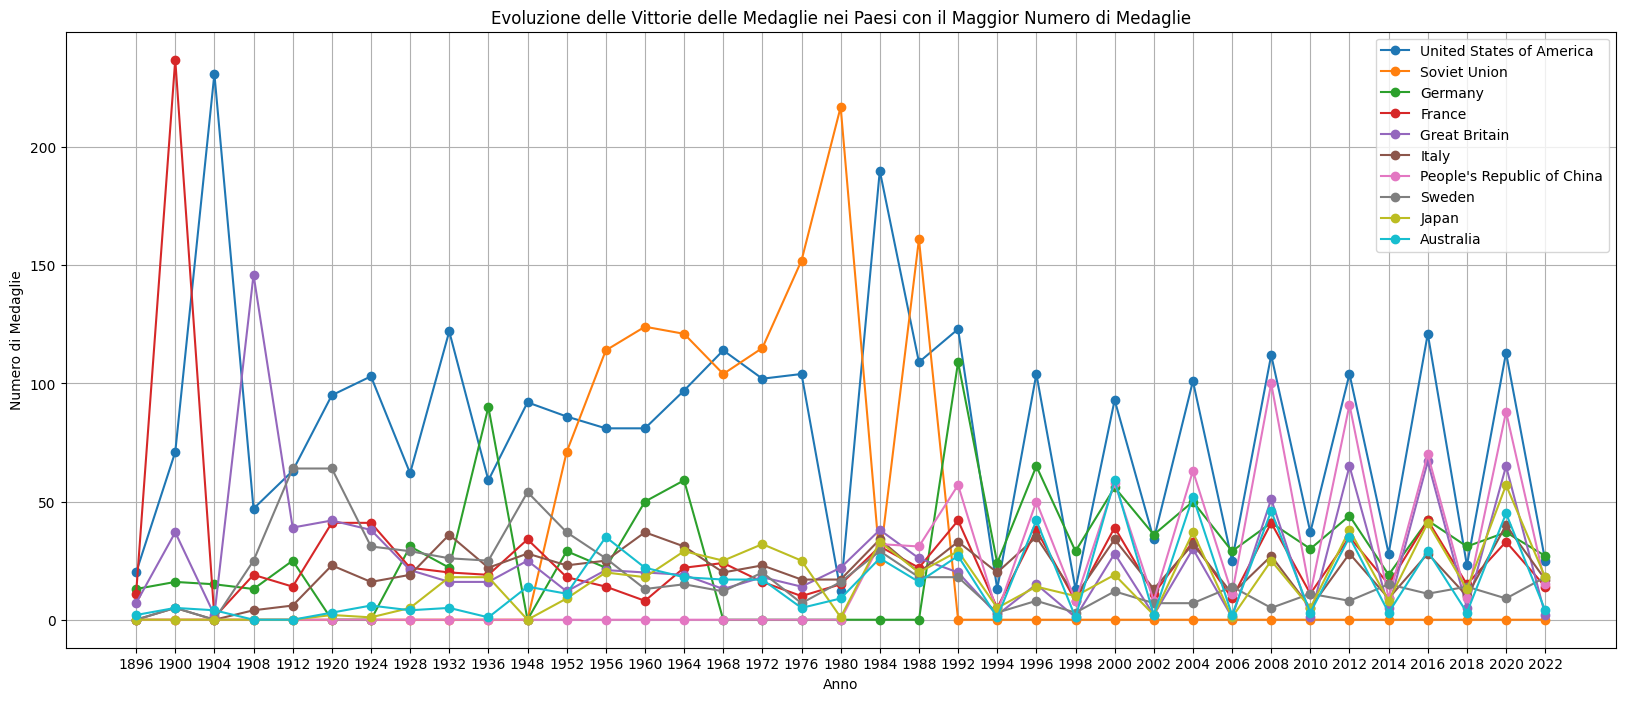

In [ ]:
medal_results = results[results['rank_position'].isin([1, 2, 3])]

medals_per_year = medal_results.groupby(['slug_game', 'country_name'], observed=False).size().reset_index(name='medal_count')

top_countries = medals_per_year.groupby('country_name', observed=False)['medal_count'].sum().nlargest(10).index

top_countries_medals = medals_per_year[medals_per_year['country_name'].isin(top_countries)]

plt.figure(figsize=(20, 8))

for country in top_countries:
    country_data = top_countries_medals[top_countries_medals['country_name'] == country]
    plt.plot(country_data['slug_game'], country_data['medal_count'], marker='o', label=country)

plt.xlabel('Anno')
plt.ylabel('Numero di Medaglie')
plt.title('Evoluzione delle Vittorie delle Medaglie nei Paesi con il Maggior Numero di Medaglie')
plt.legend()
plt.grid(True)
plt.show()


Dopo aver analizzato i valori nulli presenti nel dataset, abbiamo osservato che ci sono 18.053 valori nulli nella colonna rank_position. Poiché rank_position è una feature cruciale per la nostra analisi e dovremo prevederne i valori, abbiamo deciso di eliminare le righe che contengono valori nulli in questa colonna per garantire la qualità e l'affidabilità del nostro modello.

In [ ]:
# Gestione dei valori nulli
nan_counts = results.isna().sum()
print("Numero valori nulli:\n", nan_counts)
nan_counts = results.isna().sum()
print("\n\nNumero valori nulli senza valori nulli in rank_position:\n", nan_counts)

Numero valori nulli:
 event_title             0
slug_game               0
participant_type        0
athletes            13184
rank_equal              0
rank_position       18053
country_name            0
value_unit          84158
value_type          72755
dtype: int64


Numero valori nulli senza valori nulli in rank_position:
 event_title             0
slug_game               0
participant_type        0
athletes            13184
rank_equal              0
rank_position       18053
country_name            0
value_unit          84158
value_type          72755
dtype: int64


**Preprocessing dei dati**

Per prima cosa, possiamo eliminare i valori nulli, riscontrati in rank_position e athletes.

In [ ]:
results = results.dropna(subset=['rank_position'])
results = results.dropna(subset=['athletes'])

La grande quantità di valori nulli in value_unit e value_type è data dal fatto che, per alcune discipline, non viene calcolato un punteggio che rappresenti la performance degli atleti.
Dal momento che ogni disciplina ha metodi diversi di calcolare i propri punteggi, si è deciso di non considerare le features value_unit e value_type come significative.
Si procede quindi ad eliminarle dal dataset.

In [ ]:
results.drop(columns=['value_unit', 'value_type'], inplace=True)

<ipython-input-167-50ed2e38a54d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results.drop(columns=['value_unit', 'value_type'], inplace=True)


Dal momento che il nostro modello si pone l'obiettivo di predire i risultati di edizioni dei Giochi Olimpici future, possiamo semplificare ulteriormente il dataset, eliminando paesi che non potranno partecipare in future edizioni, ed aggiornando il nome di alcuni paesi.

In [ ]:
results['country_name'] = results['country_name'].replace("Federal Republic of Germany", "Germany")
results['country_name'] = results['country_name'].replace("German Democratic Republic (Germany)", "Germany")
results['country_name'] = results['country_name'].replace("Saar", "Germany")

results['country_name'] = results['country_name'].replace("Yemen Arab Republic", "Yemen")
results['country_name'] = results['country_name'].replace("Yemen Democratic Republic", "Yemen")

results['country_name'] = results['country_name'].replace("South Vietnam", "Socialist Republic of Vietnam")

results['country_name'] = results['country_name'].replace("Rhodesia", "Zimbabwe")

results['country_name'] = results['country_name'].replace("Malaya", "Malaysia")

results['country_name'] = results['country_name'].replace("Bohemia", "Czech Republic")

<ipython-input-168-a9c4a40bafa8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['country_name'] = results['country_name'].replace("Federal Republic of Germany", "Germany")
<ipython-input-168-a9c4a40bafa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['country_name'] = results['country_name'].replace("German Democratic Republic (Germany)", "Germany")
<ipython-input-168-a9c4a40bafa8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [ ]:
results = results.loc[~results['country_name'].isin(["Netherlands Antilles","Serbia and Montenegro", "Czechoslovakia", "Yugoslavia", "Soviet Union", "United Arab Republic", "West Indies Federation", "Australasia"])]


In [ ]:
# Viene separata la città e l'anno

def extract_location_and_year(slug_game):
    location, year = slug_game.rsplit('-', 1)  # Split the string at the last occurrence of '-'
    return location, year

results['year'] = results['slug_game'].apply(lambda x: extract_location_and_year(x)[1])

results['year'] = pd.to_numeric(results['year'])

results['slug_game'] = results['slug_game'].apply(lambda x: extract_location_and_year(x)[0])

results.rename(columns={'slug_game': 'location'}, inplace=True)

In [ ]:
# grafico che mostra come l'età possa essere un indice importante per la determinazione del rank
res = results.copy()
res.reset_index(inplace=True)
res = res.dropna(subset=['athletes'])

res['athletes'] = res['athletes'].astype(str)
res['athletes'] = res['athletes'].apply(lambda x: x.split(', '))
res = res.explode('athletes')

merged_df = pd.merge(res, athletes, left_on='athletes', right_on='athlete_full_name', how='left')
filtered_df = merged_df[['athlete_full_name', 'rank_position', 'year', 'athlete_year_birth']].copy()
filtered_df['age'] = filtered_df['year'] - filtered_df['athlete_year_birth']
filtered_df = filtered_df[(filtered_df['rank_position'].isin([1, 2, 3])) & (filtered_df['age'] > 11) & (filtered_df['age'] < 72)]

bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
labels = ['10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74']

filtered_df['age_group'] = pd.cut(filtered_df['age'], bins=bins, labels=labels, right=False)

medal_counts = filtered_df.groupby('age_group', observed=False)['rank_position'].count().reset_index(name='medal_count')

plt.figure(figsize=(10, 6))

plt.bar(medal_counts['age_group'], medal_counts['medal_count'], color='skyblue', edgecolor='w')
plt.xlabel('Fascia di Età')
plt.ylabel('Numero di Medaglie')
plt.title('Numero di Medaglie per Fascia di Età (Top 3 Posti)')
plt.grid(axis='y')
plt.show()

In [ ]:
athlete_birth_year_dict = athletes.set_index('athlete_full_name')['athlete_year_birth'].to_dict()
results.dropna(subset=['athletes'], inplace=True)

# Funzione per calcolare l'età o la media delle età
def calculate_age(athlete_names, year):
  athlete_names_list = athlete_names.split(', ')
  ages = [(year - athlete_birth_year_dict[athlete]) for athlete in athlete_names_list if athlete in athlete_birth_year_dict]
  if ages:
    return sum(ages) / len(ages)  # Media delle età

results['age'] = results.apply(lambda row: calculate_age(row['athletes'], row['year']), axis=1)

filtered_df = results[['athletes', 'rank_position', 'year', 'age']].copy()
filtered_df = filtered_df[(filtered_df['rank_position'].isin([1, 2, 3])) & (filtered_df['age'] > 11) & (filtered_df['age'] < 72)]

bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
labels = ['10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74']

filtered_df['age_group'] = pd.cut(filtered_df['age'], bins=bins, labels=labels, right=False)

medal_counts = filtered_df.groupby('age_group', observed=False)['rank_position'].count().reset_index(name='medal_count')

plt.figure(figsize=(10, 6))

plt.bar(medal_counts['age_group'], medal_counts['medal_count'], color='skyblue', edgecolor='w')
plt.xlabel('Fascia di Età')
plt.ylabel('Numero di Medaglie')
plt.title('Numero di Medaglie per Fascia di Età (Top 3 Posti)')
plt.grid(axis='y')
plt.show()